# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:13<00:00, 1884.65it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:

preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [02:12<00:00, 2747.27it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaa']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 116756)
the number of unique words  116756


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaaa', 'aaah', 'aafco', 'ab', 'aback', 'abandon', 'abandoned', 'abbey']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 203034)
the number of unique words including both unigrams and bigrams  203034


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.8946336507797241), ('fantastic', 0.8892163634300232), ('awesome', 0.8583937883377075), ('good', 0.8551861047744751), ('excellent', 0.8535214066505432), ('wonderful', 0.8254380822181702), ('perfect', 0.7960960268974304), ('fabulous', 0.7550334930419922), ('nice', 0.7538446187973022), ('amazing', 0.7521381378173828)]
[('nastiest', 0.8621901869773865), ('greatest', 0.7646499872207642), ('disgusting', 0.7523614764213562), ('best', 0.7197562456130981), ('terrible', 0.7177380323410034), ('horrible', 0.7129316926002502), ('vile', 0.6810699701309204), ('weakest', 0.6789683699607849), ('awful', 0.6711582541465759), ('tastiest', 0.6682080626487732)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  33573
sample words  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'whales', 'india', 'drooping', 'roses', 'love', 'new', 'words', 'introduces', 'silliness', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'grew', 'reading', 'sendak', 'books', 'watching', 'really', 'rosie', 'movie', 'incorporates', 'loves', 'however', 'miss', 'hard', 'cover', 'version', 'seem', 'kind', 'flimsy', 'takes']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [28]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


In [25]:
# Function to plot confusion matrix
def confusion_matrix_plot(test_y, predict_y):
    # C stores the confusion matrix 
    C = confusion_matrix(test_y, predict_y)
    
    
    # Class labels 
    labels_x = ["Predicted No","Predicted Yes"]
    labels_y = ["Original No","Original Yes"]
    
    cmap=sns.light_palette("orange")
    print("Confusion matrix")
    plt.figure(figsize=(4,4))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_x, yticklabels=labels_y)
    plt.show()

In [26]:
# Function to plot roc curve

def plot_roc_curve(Y_test,predict_y_test,Y_train,predict_y_train):
    fpr1,tpr1,threshold1 = roc_curve(Y_test,predict_y_test) # For test dataset
    fpr2,tpr2,threshold2 = roc_curve(Y_train,predict_y_train) # For train dataset
    
    plt.plot([0,1],[0,1])
    plt.plot(fpr1,tpr1,label="Test AUC")
    plt.plot(fpr2,tpr2,label="Train AUC")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [34]:
import math
# Plotting graph of auc and parameter for training and cross validation error
alpha1 = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha2 = [math.log10(i) for i in alpha1]
def plot_train_vs_auc(train_auc_list,cv_auc_list):
    plt.plot(alpha2,train_auc_list,label="Train AUC")
    plt.xlabel("Hyper-parameter alpha")
    plt.ylabel("Area Under Curve")
    plt.plot(alpha2,cv_auc_list,label="Validation AUC")
    plt.legend()
    plt.show()

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

<h3>On Uni-grams</h3>

In [214]:
# Initializing BagOfWords
bow_vect = CountVectorizer()

# Spplitting data into train and test
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit

X = preprocessed_reviews
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train),len(X_test))

254919 109252


In [36]:
# Vectorizing the reviews 
train_vect = bow_vect.fit_transform(X_train)
test_vect = bow_vect.transform(X_test)

print(train_vect.shape)

(254919, 96683)


In [37]:
# Creating a list of alpha values to calculate best alpha
alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

In [38]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from tqdm import tqdm  # this module is used to check the progress of loops
# In this section we will train naive bayes model and find training error for various alpha value

train_auc_list = [] # Stores area under curve for each alpha value

for k  in tqdm(alpha):
    clf = MultinomialNB(alpha=k)
    
    # Trainig our model
    clf.fit(train_vect,Y_train)
    
    predict_probab = clf.predict_log_proba(train_vect)[:,1] # Returns probability for positive class only
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.28it/s]


In [39]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(alpha):
    # Naive bayes classifier
    clf = MultinomialNB(alpha=k)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_vect):
        x_train = train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        
        

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:42<00:00,  3.85s/it]


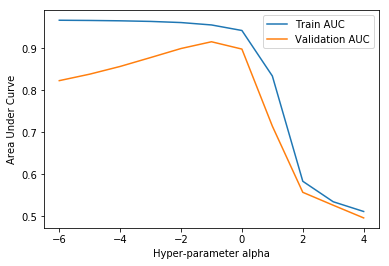

In [40]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [41]:
# Here best validation and train AUC occurs at -1 which means at alpha 0.1 as we took log10() of alpha on x-axis.
# Initializing model
final_clf = MultinomialNB(alpha=0.1)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_vect)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Naive Bayes is {:.3f}".format(auc))

Final AUC for BoW Naive Bayes is 0.925


For test datset
Confusion matrix


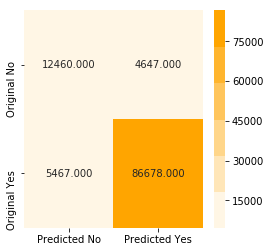

In [43]:
# Plotting confusion matrix for train
print("For test datset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


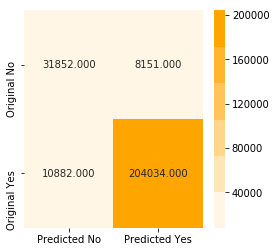

In [44]:
# Plotting confusion matrix for test 
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

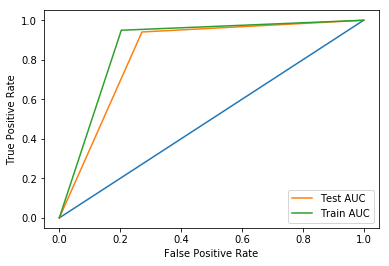

In [45]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h4>Hyperparameter tuning using GridSearch CV</h4>

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = MultinomialNB()


# Dictionary of parameters to be searched on 
parameters = {'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=3)

# Training the gridsearchcv instance
grid_model.fit(train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_vect)
predict_y_train = optimized_clf.predict(train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.925


In [47]:
print(grid_model.best_params_)

{'alpha': 0.1}


For test dataset
Confusion matrix


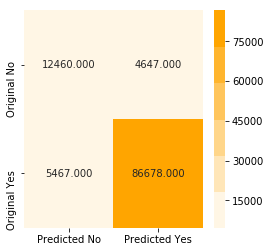

In [48]:
# Plotting confusion matrix for train
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


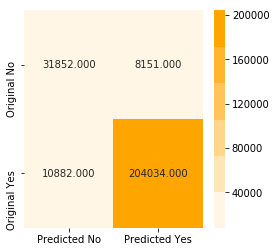

In [49]:
# Plotting confusion matrix for test
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

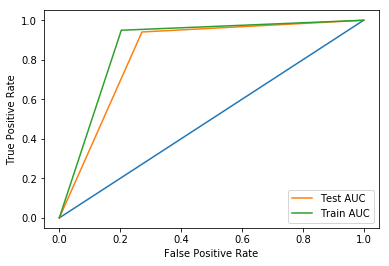

In [47]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h3>Observation</h3>
<h4>1. The AUC score improves by 1 percent when hyper-parameter tuning is done using grid-search</h4>

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [50]:
import numpy as np
# Top 10 features log probability

# Sorting all probability in ascending and getting their index
positive_top10 = final_clf.feature_log_prob_[1,:].argsort()  

# Getting last 10 features as they have largest prob value
top10_features = [bow_vect.get_feature_names()[i] for i in positive_top10[-10:]]

print("Top 10 feature for positive class are ::",top10_features)

Top 10 feature for positive class are :: ['love', 'coffee', 'tea', 'product', 'taste', 'one', 'great', 'good', 'like', 'not']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [51]:
# Top 10 features for negative class

# Sorting all probability in ascending and getting their index
negative_top10 = optimized_clf.feature_log_prob_[0,:].argsort()

# Getting last 10 features as they have largest prob value
top10_features = [bow_vect.get_feature_names()[i] for i in negative_top10[-10:]]

print("Top 10 feature for negative class are ::",top10_features)

Top 10 feature for negative class are :: ['flavor', 'coffee', 'no', 'good', 'one', 'taste', 'would', 'product', 'like', 'not']


<h3>On bigrams</h3>

In [52]:
# Initializing BagOfWords
bow_vect = CountVectorizer(ngram_range=(2,2))

# Spplitting data into train and test
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import TimeSeriesSplit

X = preprocessed_reviews
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train),len(X_test))

254919 109252


In [53]:
# Vectorizing the reviews 
train_vect = bow_vect.fit_transform(X_train)
test_vect = bow_vect.transform(X_test)
print(train_vect.shape)

(254919, 2973643)


In [54]:
# In this section we will train naive bayes model and find training error for various alpha value

train_auc_list = [] # Stores area under curve for each alpha value

for k  in tqdm(alpha):
    clf = MultinomialNB(alpha=k)
    
    # Trainig our model
    clf.fit(train_vect,Y_train)
    
    predict_probab = clf.predict_log_proba(train_vect)[:,1] # Returns probability for positive class only
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.01s/it]


In [55]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(alpha):
    # Naive bayes classifier
    clf = MultinomialNB(alpha=k)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_vect):
        x_train = train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        
        

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:29<00:00,  8.19s/it]


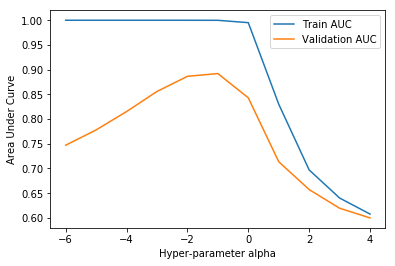

In [56]:
# Plotitng paramter vs auc curve

plot_train_vs_auc(train_auc_list,cv_auc_list)

In [57]:
# Taking best value of alpha = 0.1 an trainig final model
# Initializing model
final_clf = MultinomialNB(alpha=0.1)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_vect)
auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Naive Bayes is {:.3f}".format(auc))

Final AUC for BoW Naive Bayes is 0.921


For test dataset
Confusion matrix


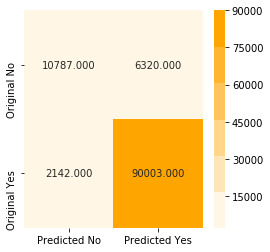

In [58]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


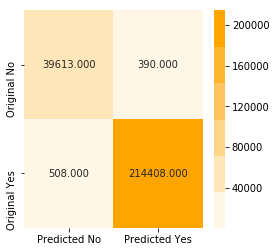

In [59]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

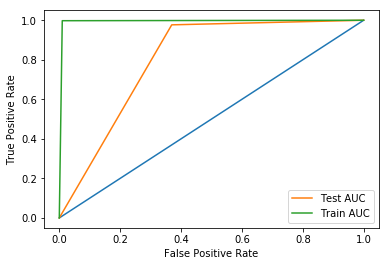

In [60]:
# Plotting ROC AUC curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h3>Hyper parameter tunning using GridSearchCV</h3>

In [187]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = MultinomialNB()

# Dictionary of parameters to be searched on 
parameters = {'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=3)

# Training the gridsearchcv instance
grid_model.fit(train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_vect)
predict_y_train = optimized_clf.predict(train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.928


In [188]:
# Printing best parameter selected by grid search
print(grid_model.best_params_)

{'alpha': 0.1}


For test data
Confusion matrix


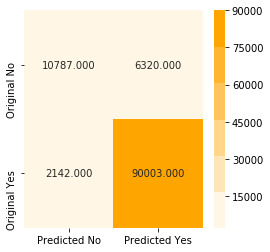

In [62]:
# Plotting confusion matrix
print("For test data")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


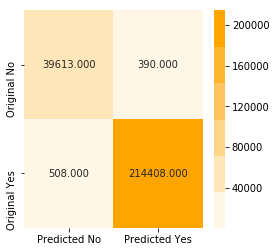

In [63]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

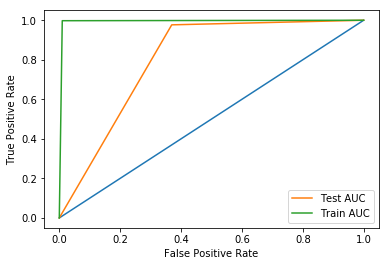

In [64]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

In [65]:
# Top 10 features log probability
positive_top10 = optimized_clf.feature_log_prob_[1,:].argsort()

top10_features = [bow_vect.get_feature_names()[i] for i in positive_top10[-10:]]

print("Top 10 feature for positive class are ::",top10_features)

Top 10 feature for positive class are :: ['much better', 'taste like', 'would not', 'green tea', 'peanut butter', 'grocery store', 'could not', 'not like', 'highly recommend', 'gluten free']


In [66]:
# Top 10 features for negative class
negative_top10 = optimized_clf.feature_log_prob_[0,:].argsort()

top10_features = [bow_vect.get_feature_names()[i] for i in negative_top10[-10:]]

print("Top 10 feature for negative class are ::",top10_features)

Top 10 feature for negative class are :: ['not know', 'tastes like', 'not good', 'not taste', 'taste like', 'not like', 'could not', 'not buy', 'not even', 'would not']


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

<h3>On Uni-grams</h3>

In [67]:
# Initializing Tfidf model
tfidf_vect = TfidfVectorizer()

X = preprocessed_reviews
Y = final['Score']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
print(len(X_train),len(X_test))

254919 109252


In [68]:

# Vectorizing the reviews 
train_vect = tfidf_vect.fit_transform(X_train)
test_vect = tfidf_vect.transform(X_test)
print(train_vect.shape)

(254919, 96683)


In [69]:
# In this section we will train naive bayes model and find training error for various alpha value
train_auc_list = [] # Stores area under curve for each alpha value

for k in tqdm(alpha):
    clf = MultinomialNB(alpha=k)
    
    # Trainig our model
    clf.fit(train_vect,Y_train)
    
    predict_probab = clf.predict_log_proba(train_vect)[:,1] # Returns probability for positive class only
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.76it/s]


In [70]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(alpha):
    # Naive bayes classifier
    clf = MultinomialNB(alpha=k)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_vect):
        x_train = train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        
        

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:39<00:00,  3.61s/it]


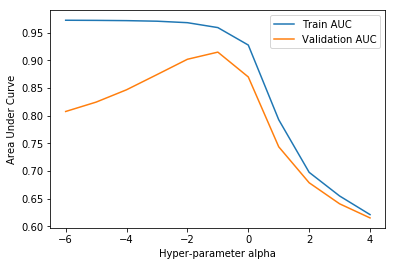

In [71]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [72]:
# Taking best value of alpha = 0.1 an trainig final model
# Initializing model
final_clf = MultinomialNB(alpha=0.1)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_vect)

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for Tfidf Naive Bayes is {:.3f}".format(auc))

Final AUC for Tfidf Naive Bayes is 0.932


For test dataset
Confusion matrix


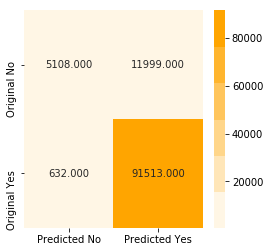

In [73]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


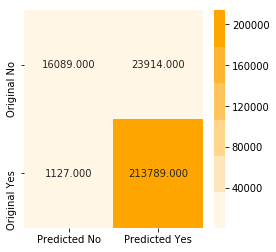

In [74]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

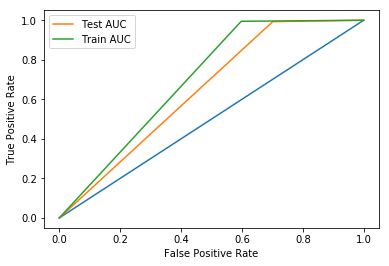

In [75]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h3>Hyper-parameter tunning using GridSearchCV</h3>

In [76]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = MultinomialNB()

# Dictionary of parameters to be searched on 
parameters = {'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=3)

# Training the gridsearchcv instance
grid_model.fit(train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_vect)
predict_y_train = optimized_clf.predict(train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.919


In [77]:
print(grid_model.best_params_)

{'alpha': 0.01}


For test dataset
Confusion matrix


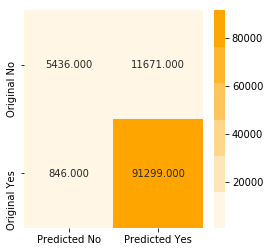

In [78]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


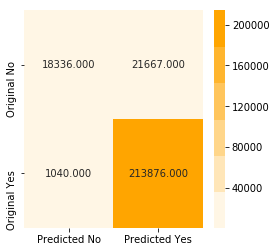

In [79]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

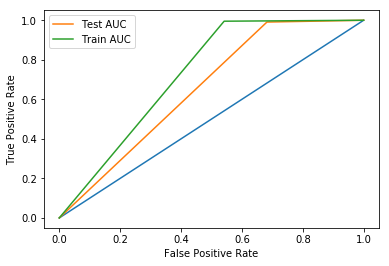

In [80]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [81]:
# Top 10 features log probability
positive_top10 = optimized_clf.feature_log_prob_[1,:].argsort() # Sorts all the probability in ascending order

top10_features = [tfidf_vect.get_feature_names()[i] for i in positive_top10[-10:]]# Takes top 10 features 
print("Top 10 feature for positive class are ::",top10_features)

Top 10 feature for positive class are :: ['one', 'taste', 'product', 'love', 'tea', 'coffee', 'like', 'good', 'great', 'not']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [82]:
# Top 10 features for negative class
negative_top10 = optimized_clf.feature_log_prob_[0,:].argsort()

top10_features = [tfidf_vect.get_feature_names()[i] for i in negative_top10[-10:]]
print("Top 10 feature for negative class are ::",top10_features)

Top 10 feature for negative class are :: ['good', 'no', 'flavor', 'one', 'coffee', 'would', 'taste', 'product', 'like', 'not']


<h3>On Bigrams</h3>

In [83]:
# Initializing Tfidf model
tfidf_vect = TfidfVectorizer(ngram_range=(2,2))

# Vectorizing the reviews 
train_vect = tfidf_vect.fit_transform(X_train)
test_vect = tfidf_vect.transform(X_test)
print(train_vect.shape)

(254919, 2973643)


In [84]:
# In this section we will train naive bayes model and find training error for various alpha value

train_auc_list = [] # Stores area under curve for each alpha value

for k  in tqdm(alpha):
    clf = MultinomialNB(alpha=k)
    
    # Trainig our model
    clf.fit(train_vect,Y_train)
    
    predict_probab = clf.predict_log_proba(train_vect)[:,1] # Returns probability for positive class only
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:10<00:00,  1.05it/s]


In [85]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(alpha):
    # Naive bayes classifier
    clf = MultinomialNB(alpha=k)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(train_vect):
        x_train = train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        
        

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:27<00:00,  7.81s/it]


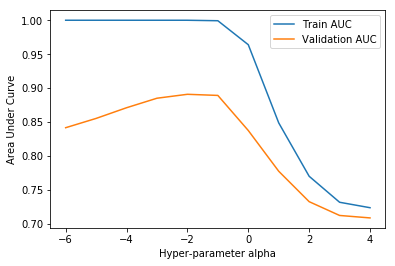

In [86]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [87]:
# Taking best value of alpha = 0.01 an trainig final model
# Initializing model
final_clf = MultinomialNB(alpha=0.01)

# Training final model
final_clf.fit(train_vect,Y_train)

predict_y = final_clf.predict(test_vect)
predict_probab = final_clf.predict_log_proba(test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(train_vect)

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Naive Bayes is {:.3f}".format(auc))

Final AUC for BoW Naive Bayes is 0.936


Confusion matrix


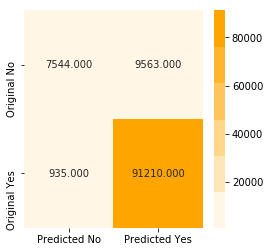

In [75]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


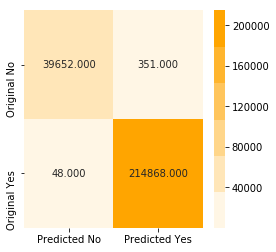

In [88]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

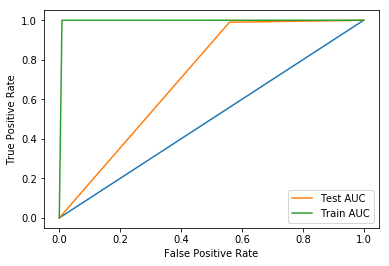

In [89]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h3>Tunning hyper parameter using GridSearchCV</h3>

In [77]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = MultinomialNB()

# Dictionary of parameters to be searched on 
parameters = {'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=3)

# Training the gridsearchcv instance
grid_model.fit(train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(test_vect)
predict_y_train = optimized_clf.predict(train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.936


In [90]:
# Printing best classifier choosen by GridSearchCV
print(grid_model.best_params_)

{'alpha': 0.01}


For test dataset
Confusion matrix


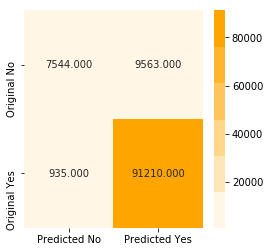

In [91]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


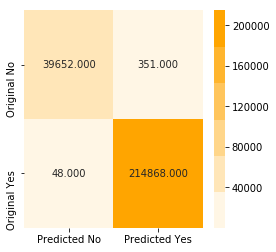

In [92]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

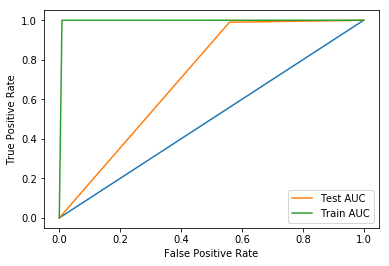

In [93]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

In [94]:
# Top 10 features log probability
# This contains index of most important positive features in ascending order.
positive_top10 = optimized_clf.feature_log_prob_[1,:].argsort()

# we will take fetaures corresponding to the last 10 index in positive_top10
top10_features = [tfidf_vect.get_feature_names()[i] for i in positive_top10[-10:]]
print("Top 10 feature for positive class are ::",top10_features)

Top 10 feature for positive class are :: ['almost haribo', 'amd chili', 'also diabetes', 'alaska dog', 'america gmo', 'ad says', 'aisle average', 'affected flavor', 'afford tasty', 'almond spread']


In [95]:
# Top 10 features for negative class
# This contains index of most important negative features in ascending order.
negative_top10 = optimized_clf.feature_log_prob_[0,:].argsort()

# we will take fetaures corresponding to the last 10 index in negative_top10
top10_features = [tfidf_vect.get_feature_names()[i] for i in negative_top10[-10:]]
print("Top 10 feature for negative class are ::",top10_features)

Top 10 feature for negative class are :: ['affected flavor', 'almond bad', 'adult made', 'almost haribo', 'ad says', 'another shown', 'amd chili', 'also diabetes', 'aisle average', 'almond spread']


<h1>Using review length as a feature </h1>

In [96]:
# Calculating and storing length of each review in train data set, in an numpy array

train_review_len = np.zeros(len(X_train))
i=0
for sent in X_train:
    train_review_len[i] = len(sent)
    i += 1

print(train_review_len.shape)

(254919,)


In [97]:
# Calculating and storing length of each review in train data set, in an numpy array

test_review_len = np.zeros(len(X_test))
i=0
for sent in X_test:
    test_review_len[i] = len(sent)
    i += 1

print(test_review_len.shape)

(109252,)


<h2>Using bow for vectorization</h2>

In [115]:
# vectorizing train and test dataset using bow
bow_train_vect = bow_vect.fit_transform(X_train)
bow_test_vect = bow_vect.transform(X_test)

In [116]:
print(bow_train_vect.shape)

(254919, 2973643)


In [117]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

# now we will add review length as a new feature to train  data set
# The shape of train_review_len is 254919 and hstack takes compatible matrices only 
# Making the train_review_len to bow_train_vect
A = coo_matrix([train_review_len]).T

bow_train_vect = hstack([bow_train_vect,A])
print(bow_train_vect.shape)

(254919, 2973644)


In [118]:
# now we will add review length as a new feature to train  data set
# Since hstack takes compatible matrices only 
# Making the test_review_len to bow_test_vect
B = coo_matrix([test_review_len]).T
bow_test_vect = hstack([bow_test_vect,B])
print(bow_test_vect.shape)

(109252, 2973644)


In [123]:
from scipy import sparse
# Converting bow_train_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
print(type(bow_train_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [127]:
# Doing same as above for test dataset
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>


In [124]:
# In this section we will train naive bayes model and find training error for various alpha value

train_auc_list = [] # Stores area under curve for each alpha value

for k  in tqdm(alpha):
    clf = MultinomialNB(alpha=k)
    
    # Trainig our model
    clf.fit(bow_train_vect,Y_train)
    
    predict_probab = clf.predict_log_proba(bow_train_vect)[:,1] # Returns probability for positive class only
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.14it/s]


In [125]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

from sklearn.model_selection import TimeSeriesSplit
# Time series object
tscv = TimeSeriesSplit(n_splits=10)

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(alpha):
    # Naive bayes classifier
    clf = MultinomialNB(alpha=k)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:29<00:00,  7.90s/it]


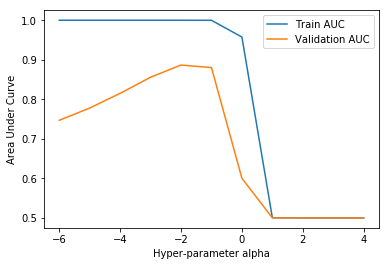

In [128]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [133]:
# Taking best value of alpha = 0.1 an trainig final model
# 0.1 was selected instead of 0.01 because at 0.1 training AUC is less compared to AUC at 0.01
# Initializing model
final_clf = MultinomialNB(alpha=0.1)

# Training final model
final_clf.fit(bow_train_vect,Y_train)

predict_y = final_clf.predict(bow_test_vect)
predict_probab = final_clf.predict_log_proba(bow_test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(bow_train_vect)

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Naive Bayes is {:.3f}".format(auc))

Final AUC for BoW Naive Bayes is 0.915


For test dataset
Confusion matrix


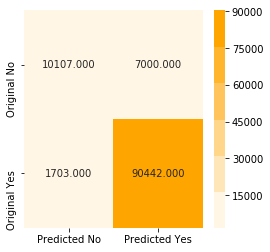

In [134]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


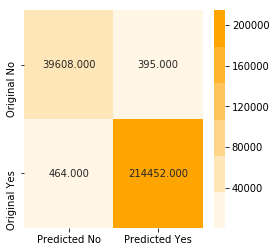

In [135]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

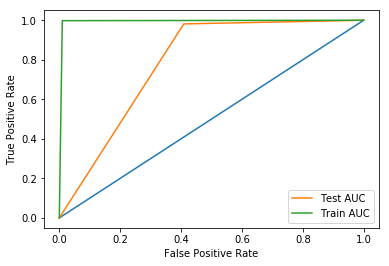

In [136]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h3>Performing hyper parameter tunning using GridSearchCV</h3> 

In [137]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = MultinomialNB()

# Dictionary of parameters to be searched on 
parameters = {'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=3)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.915


In [138]:
# Prints best alpha selected by GridSearchCV
print(grid_model.best_params_)

{'alpha': 0.1}


For test dataset
Confusion matrix


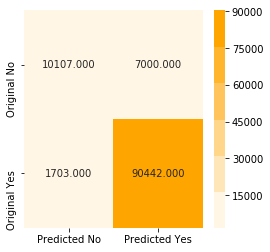

In [139]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


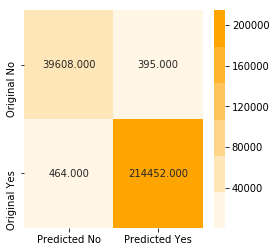

In [140]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

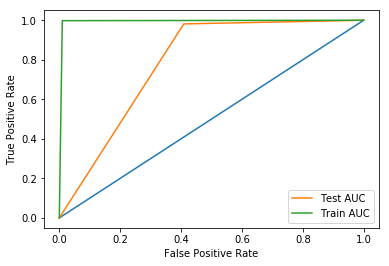

In [141]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h2>Using Tfidf for vectorization</h2>

In [142]:
# vectorizing train and test dataset using bow
tfidf_vect = TfidfVectorizer()
tfidf_train_vect = tfidf_vect.fit_transform(X_train)
tfidf_test_vect = tfidf_vect.transform(X_test)

In [143]:
# now we will add review length as a new feature to train  data set
# The shape of train_review_len is 254919 and hstack takes compatible matrices only 
# Making the train_review_len to bow_train_vect
tfidf_train_vect = hstack([tfidf_train_vect,A])
print(tfidf_train_vect.shape)

(254919, 96684)


In [144]:
# now we will add review length as a new feature to test data set
# The shape of train_review_len is 254919 and hstack takes compatible matrices only 
# Making the train_review_len to bow_train_vect
tfidf_test_vect = hstack([tfidf_test_vect,B])
print(tfidf_test_vect.shape)

(109252, 96684)


In [145]:
# Converting tfidf_train_vect and tfidf_test_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

tfidf_train_vect = sparse.csr_matrix(tfidf_train_vect)
tfidf_test_vect = sparse.csr_matrix(tfidf_test_vect)
print(type(tfidf_train_vect))
print(type(tfidf_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [146]:
# In this section we will train naive bayes model and find training error for various alpha value

train_auc_list = [] # Stores area under curve for each alpha value

for k  in tqdm(alpha):
    clf = MultinomialNB(alpha=k)
    
    # Trainig our model
    clf.fit(tfidf_train_vect,Y_train)
    
    predict_probab = clf.predict_log_proba(tfidf_train_vect)[:,1] # Returns probability for positive class only
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  2.84it/s]


In [147]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

# Time series object
tscv = TimeSeriesSplit(n_splits=10)

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(alpha):
    # Naive bayes classifier
    clf = MultinomialNB(alpha=k)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(tfidf_train_vect):
        x_train = tfidf_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = tfidf_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:40<00:00,  3.63s/it]


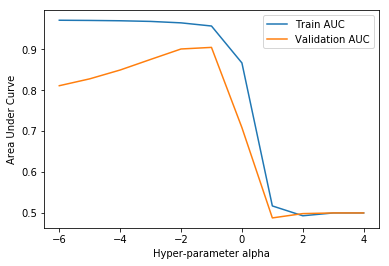

In [148]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [149]:
# Taking best value of alpha = 0.1 an trainig final model
# Initializing model
final_clf = MultinomialNB(alpha=0.1)

# Training final model
final_clf.fit(bow_train_vect,Y_train)

predict_y = final_clf.predict(bow_test_vect)
predict_probab = final_clf.predict_log_proba(bow_test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(bow_train_vect)

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for Tfidf Naive Bayes is {:.3f}".format(auc))

Final AUC for Tfidf Naive Bayes is 0.915


For test dataset
Confusion matrix


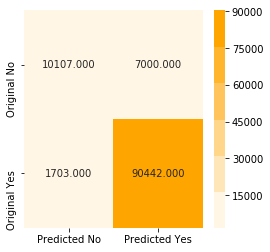

In [150]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


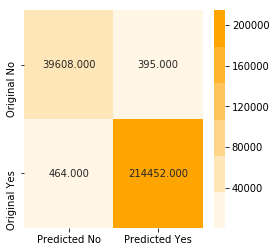

In [151]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

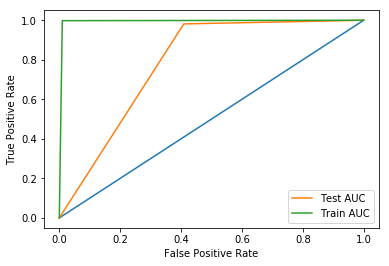

In [152]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h2>Performing hyper parameter tunning using GridSearchCV</h2>

In [153]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = MultinomialNB()

# Dictionary of parameters to be searched on 
parameters = {'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=3)

# Training the gridsearchcv instance
grid_model.fit(tfidf_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(tfidf_test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(tfidf_test_vect)
predict_y_train = optimized_clf.predict(tfidf_train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.917


In [154]:
# Printing best alpha selected by GriddSearch
print(grid_model.best_params_)

{'alpha': 0.01}


For test dataset
Confusion matrix


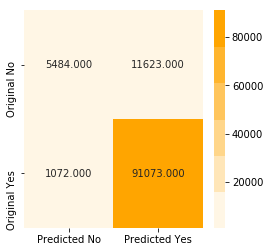

In [155]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


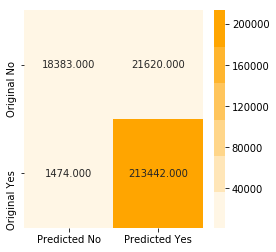

In [156]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

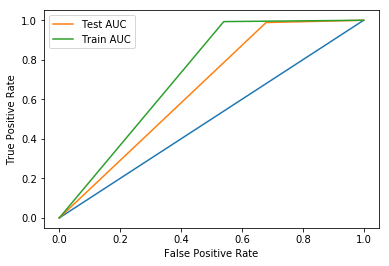

In [157]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h2>Extracting features from summary</h2>

<h2>Bag of Words</h2>

In [202]:
# Splitting summary into train and test 
train_summ,test_summ,Y_train_summ,Y_test_summ = train_test_split(preprocessed_summary,Y,test_size=0.3,random_state=42)

In [159]:
# Using bag of words to vectorize summary
# For train dataset
count_vect = CountVectorizer()
train_vect = count_vect.fit_transform(train_summ)
print(train_vect.shape)

# for test dataset
test_vect = count_vect.transform(test_summ)
print(test_vect.shape)

(254919, 26288)
(109252, 26288)


In [160]:
# now we will add vectorized review as a new feature to train  data set
bow_train_vect = hstack([bow_train_vect,train_vect])
print(bow_train_vect.shape)

(254919, 2999932)


In [161]:
# now we will add vectorized review as a new feature to train  data set
bow_test_vect = hstack([bow_test_vect,test_vect])
print(bow_test_vect.shape)

(109252, 2999932)


In [162]:
# Converting tfidf_train_vect and tfidf_test_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

bow_train_vect = sparse.csr_matrix(bow_train_vect)
bow_test_vect = sparse.csr_matrix(bow_test_vect)
print(type(bow_train_vect))
print(type(bow_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [163]:
# In this section we will train naive bayes model and find training error for various alpha value

train_auc_list = [] # Stores area under curve for each alpha value

for k  in tqdm(alpha):
    clf = MultinomialNB(alpha=k)
    
    # Trainig our model
    clf.fit(bow_train_vect,Y_train)
    
    predict_probab = clf.predict_log_proba(bow_train_vect)[:,1] # Returns probability for positive class only
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:10<00:00,  1.08it/s]


In [165]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

# Time series object
tscv = TimeSeriesSplit(n_splits=10)

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(alpha):
    # Naive bayes classifier
    clf = MultinomialNB(alpha=k)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(bow_train_vect):
        x_train = bow_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = bow_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:30<00:00,  8.16s/it]


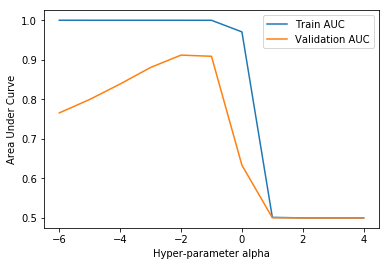

In [167]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [168]:
# Taking best value of alpha = 0.1 an trainig final model
# 0.01 was not taken as train AUC ia less at 0.1 compared to AUC at 0.01 
# Initializing model
final_clf = MultinomialNB(alpha=0.1)

# Training final model
final_clf.fit(bow_train_vect,Y_train)

predict_y = final_clf.predict(bow_test_vect)
predict_probab = final_clf.predict_log_proba(bow_test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(bow_train_vect)

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for BoW Naive Bayes is {:.3f}".format(auc))

Final AUC for BoW Naive Bayes is 0.940


For test dataset
Confusion matrix


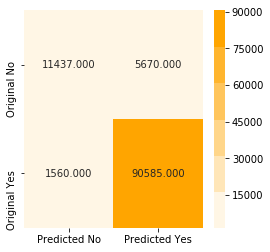

In [169]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


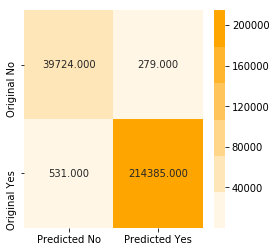

In [170]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

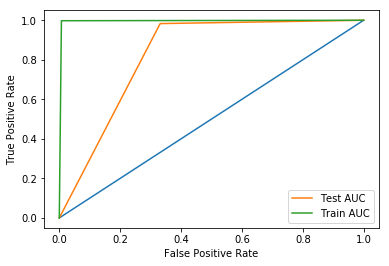

In [171]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h3>Performing hyper parameter tunning using GridSearchCV</h3> 

In [172]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = MultinomialNB()

# Dictionary of parameters to be searched on 
parameters = {'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=3)

# Training the gridsearchcv instance
grid_model.fit(bow_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(bow_test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(bow_test_vect)
predict_y_train = optimized_clf.predict(bow_train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.940


In [173]:
# Printing best parameter selected by GridSearch
print(grid_model.best_params_)

{'alpha': 0.1}


For test dataset
Confusion matrix


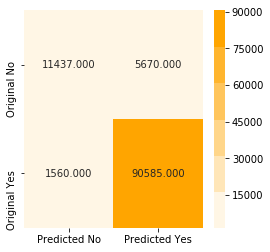

In [174]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


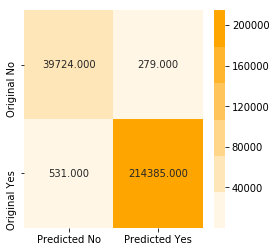

In [175]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

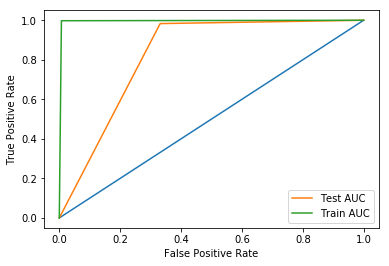

In [176]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h2>Tfidf vectorization</h2>

In [215]:
# vectorizing train and test dataset using bow
tfidf_vect = TfidfVectorizer()
tfidf_train_vect = tfidf_vect.fit_transform(X_train)
tfidf_test_vect = tfidf_vect.transform(X_test)

In [216]:
print(tfidf_train_vect.shape)
print(tfidf_test_vect.shape)

(254919, 96683)
(109252, 96683)


In [218]:
# Splitting summary into train and test 
train_summ,test_summ,Y_train_summ,Y_test_summ = train_test_split(preprocessed_summary,Y,test_size=0.3,random_state=42)

In [220]:
# Coverting summary into tfidf vectors.
tfidf_train_summ = tfidf_vect.fit_transform(train_summ)
tfidf_test_summ = tfidf_vect.transform(test_summ)
print(tfidf_train_summ.shape)
print(tfidf_test_summ.shape)

(254919, 26288)
(109252, 26288)


In [221]:
# now we will add vectorized review as a new feature to train  data set
tfidf_train_vect = hstack([tfidf_train_vect,tfidf_train_summ])
print(tfidf_train_vect.shape)

(254919, 122971)


In [222]:
# now we will add vectorized review as a new feature to train  data set
tfidf_test_vect = hstack([tfidf_test_vect,tfidf_test_summ])
print(tfidf_test_vect.shape)

(109252, 122971)


In [223]:
# Converting tfidf_train_vect and tfidf_test_vect from scipy.sparse.coo.coo_matrix to scipy.sparse.csr.csr_matrix as 
# scipy.sparse.coo.coo_matrix are not subscriptable

tfidf_train_vect = sparse.csr_matrix(tfidf_train_vect)
tfidf_test_vect = sparse.csr_matrix(tfidf_test_vect)
print(type(tfidf_train_vect))
print(type(tfidf_test_vect))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


In [224]:
# In this section we will train naive bayes model and find training error for various alpha value

train_auc_list = [] # Stores area under curve for each alpha value

for k  in tqdm(alpha):
    clf = MultinomialNB(alpha=k)
    
    # Trainig our model
    clf.fit(tfidf_train_vect,Y_train)
    
    predict_probab = clf.predict_log_proba(tfidf_train_vect)[:,1] # Returns probability for positive class only
    
    auc = roc_auc_score(Y_train,predict_probab)
    train_auc_list.append(auc)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.57it/s]


In [225]:
# We will do time based splitting and do 10 fold cross validation 
# This is done as reviews keeps changing with time and hence time based splitting is required

# Time series object
tscv = TimeSeriesSplit(n_splits=10)

cv_auc_list = [] # will contain cross validation AUC corresponding to each k 

for k in tqdm(alpha):
    # Naive bayes classifier
    clf = MultinomialNB(alpha=k)
    i=0
    auc=0.0
    for train_index,test_index in tscv.split(tfidf_train_vect):
        x_train = tfidf_train_vect[0:train_index[-1]][:] # row 0 to train_index(excluding)
        y_train = Y_train[0:train_index[-1]][:] # row 0 to train_index(excluding)
        x_test = tfidf_train_vect[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
        y_test = Y_train[train_index[-1]:test_index[-1]][:] # row from train_index to test_index(excluding) will be selected
    
        clf.fit(x_train,y_train)
    
        predict_probab = clf.predict_proba(x_test)[:,1] # returns probability for positive points
        i += 1
        auc += roc_auc_score(y_test,predict_probab)
        
    cv_auc_list.append(auc/i) # Storing AUC value
        

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:43<00:00,  4.05s/it]


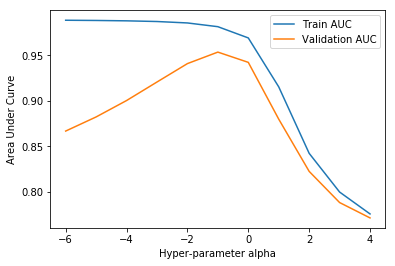

In [226]:
# Plotting graph of auc and parameter for training and cross validation error
plot_train_vs_auc(train_auc_list,cv_auc_list)

In [227]:
# Taking best value of alpha = 0.1 an trainig final model
# Initializing model
final_clf = MultinomialNB(alpha=0.1)

# Training final model
final_clf.fit(tfidf_train_vect,Y_train)

predict_y = final_clf.predict(tfidf_test_vect)
predict_probab = final_clf.predict_log_proba(tfidf_test_vect)[:,1] # Returns probabality for positive points
predict_y_train = final_clf.predict(tfidf_train_vect)

auc = roc_auc_score(Y_test,predict_probab)
print("Final AUC for tfidf Naive Bayes is {:.3f}".format(auc))

Final AUC for tfidf Naive Bayes is 0.965


For Test dataset
Confusion matrix


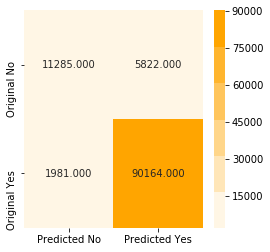

In [228]:
# Plotting confusion matrix
print("For Test dataset")
confusion_matrix_plot(Y_test,predict_y)

For Train Dataset
Confusion matrix


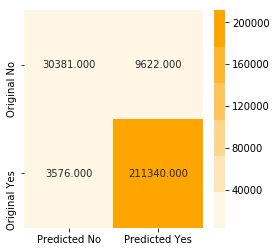

In [229]:
# Plotting confusion matrix
print("For Train Dataset")
confusion_matrix_plot(Y_train,predict_y_train)

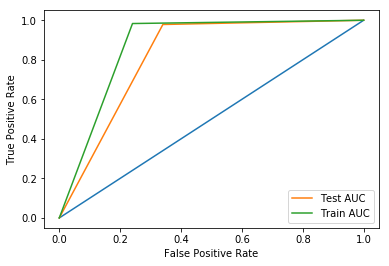

In [230]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

<h2>Hyper parameter tunning using GridSearchCV</h2>

In [231]:
# Selecting the estimator . Estimator is the model that you will use to train your model
# We will pass this instance to GridSearchCV
clf = MultinomialNB()

# Dictionary of parameters to be searched on 
parameters = {'alpha':[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}

# Value on which model will be evaluated
auc_score = make_scorer(roc_auc_score)

# Calling GridSearchCV .
grid_model = GridSearchCV(estimator = clf,param_grid=parameters,cv=10,refit=True,scoring=auc_score,n_jobs=3)

# Training the gridsearchcv instance
grid_model.fit(tfidf_train_vect,Y_train)

# this gives the best model with best hyper parameter
optimized_clf = grid_model.best_estimator_

predict_probab = optimized_clf.predict_log_proba(tfidf_test_vect)[:,1] # returns probability of positive points
predict_y = optimized_clf.predict(tfidf_test_vect)
predict_y_train = optimized_clf.predict(tfidf_train_vect)

print("AUC is {:.3f}".format(roc_auc_score(Y_test,predict_probab)))

AUC is 0.965


In [232]:
# Printing best parameter of grid search
print(grid_model.best_params_)

{'alpha': 0.1}


For test dataset
Confusion matrix


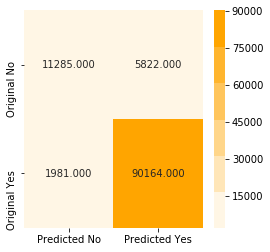

In [233]:
# Plotting confusion matrix
print("For test dataset")
confusion_matrix_plot(Y_test,predict_y)

For train dataset
Confusion matrix


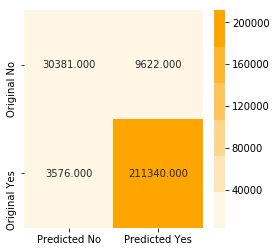

In [234]:
# Plotting confusion matrix
print("For train dataset")
confusion_matrix_plot(Y_train,predict_y_train)

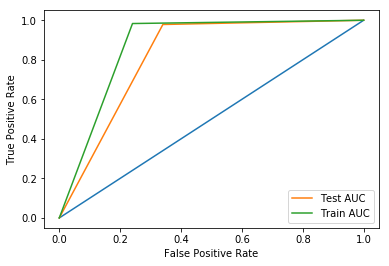

In [235]:
#Plotting ROC Curve
plot_roc_curve(Y_test,predict_y,Y_train,predict_y_train)

# [6] Conclusions

In [236]:
from prettytable import PrettyTable

# Initializing table object
x = PrettyTable()

x.field_names = ["Vectorizer","Model","Hyper-Parameter alpha","Area Under Curve"]

x.add_row([ "Bow unigram","Naive Bayes","0.1","0.925" ])
x.add_row([ "Bow bigram ","Naive Bayes","0.1","0.928" ])
x.add_row([ "Tfidf unigram","Naive Bayes","0.01","0.919" ])
x.add_row([ "Tfidf bigram ","Naive Bayes","0.01","0.936" ])
x.add_row([ "Bow with review length ","Naive Bayes","0.1","0.915" ])
x.add_row([ "Tfidf with review length ","Naive Bayes","0.1","0.917" ])
x.add_row([ "Bow with summary feature","Naive Bayes","0.1","0.940" ])
x.add_row([ "Tfidf with summary feature","Naive Bayes","0.1","0.965" ])

print(x)

+----------------------------+-------------+-----------------------+------------------+
|         Vectorizer         |    Model    | Hyper-Parameter alpha | Area Under Curve |
+----------------------------+-------------+-----------------------+------------------+
|        Bow unigram         | Naive Bayes |          0.1          |      0.925       |
|        Bow bigram          | Naive Bayes |          0.1          |      0.928       |
|       Tfidf unigram        | Naive Bayes |          0.01         |      0.919       |
|       Tfidf bigram         | Naive Bayes |          0.01         |      0.936       |
|  Bow with review length    | Naive Bayes |          0.1          |      0.915       |
| Tfidf with review length   | Naive Bayes |          0.1          |      0.917       |
|  Bow with summary feature  | Naive Bayes |          0.1          |      0.940       |
| Tfidf with summary feature | Naive Bayes |          0.1          |      0.965       |
+----------------------------+--

<h3>Explaination</h3>
<h5>Train data and test have been vectorized seperately to prevent data leak problem.</h5>
<h5>To tune hyper paarameter alpha custom 10-fold cross validation was done on Time Series Split data as reviews keeps changing with time. A graph was plotted to show train and validation AUC and best alpha was selected corresponding to best Validation AUC .</h5>
<h5>Best model was using the result of custom 10-fold cross validation and Grid Search .</h5>
<h5>To print top 10 features of positive class and negative class we did as follows:</h5>
<h5>We sorted the probability of positive and negative features using argsort in ascending order.</h5>
<h5>Then we selected features corresponding to last 10 indexes from sorted index from above step.</h5>
<h5>In feature engineering section we have used review length and summary as a feature along with reviews.</h5>
<h5>We calculated length of each review and vectorized each sumomary and then combined these with reviews using hstack.</h5>
<h5>Out of all the models BoW with summary feature had best performance although its AUC is less than model trained on Tfidf with summary feature.</h5>
